In [10]:
%load_ext autoreload
%autoreload 2

In [1]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, '..', 'tools')
models_2d_path = os.path.join(cwd, '..', 'models_25gaussians', 'jensen_minimax')
sys.path.append(api_path)

In [2]:
import numpy as np
import sklearn.datasets
import time
import random
import glob
import importlib
from tqdm import tqdm

import pyro
from pyro.infer import MCMC, NUTS, HMC
from functools import partial
import ot

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F

from torch import autograd
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

from utils import (Evolution,
                   prepare_25gaussian_data, 
                   prepare_swissroll_data,
                   prepare_gaussians,
                   prepare_train_batches,
                   prepare_dataloader,
                   logging)
from gan_fc_models import (Generator_fc, 
                           Discriminator_fc, 
                           weights_init_1, 
                           weights_init_2)
from visualization import (send_file_to_remote,
                           sample_fake_data,
                           plot_fake_data_mode,
                           plot_fake_data_projection,
                           plot_discriminator_2d,
                           plot_potential_energy,
                           mh_sampling_plot_2d,
                           langevin_sampling_plot_2d,
                           mala_sampling_plot_2d,
                           xtry_langevin_sampling_plot_2d,
                           epoch_visualization)
from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling, 
                          mala_sampling,
                          xtry_langevin_sampling,
                          gan_energy,
                          Gaussian_mixture,
                          IndependentNormal,
                          DotDict)
from params_25gaussians import (sigma,
                                random_seed,
                                train_dataset_size,
                                n_dim,
                                n_layers_d,
                                n_layers_g,
                                n_hid_d,
                                n_hid_g,
                                n_out,
                                device)

# 2D Gaussians, true distribution

In [7]:
from sklearn.preprocessing import StandardScaler

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

X_train, means = prepare_25gaussian_data(train_dataset_size,
                                         sigma, 
                                         random_seed)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [4]:
n_dim = 2
target_args = DotDict()
target_args.device = device
target_args.num_gauss = 25
n_col = 5
n_row = target_args.num_gauss // n_col
s = 1
###create points
coef_gaussian = 1./target_args.num_gauss
target_args.p_gaussians = [torch.tensor(coef_gaussian)]*target_args.num_gauss
locs = [torch.tensor([(i-2)*s,(j-2)*s] + [0]* (n_dim - 2)).to(device) 
        for i in range(n_col) for j in range(n_row)]
target_args.locs = locs
target_args.covs = [(sigma**2)*torch.eye(n_dim).to(device)]*target_args.num_gauss
target_args.dim = n_dim
true_target = Gaussian_mixture(target_args).log_prob


n_dim = 2
loc_proposal = torch.zeros(n_dim).to(device)
scale_proposal = torch.ones(n_dim).to(device)
proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc_proposal
proposal_args.scale = scale_proposal
proposal = IndependentNormal(proposal_args)

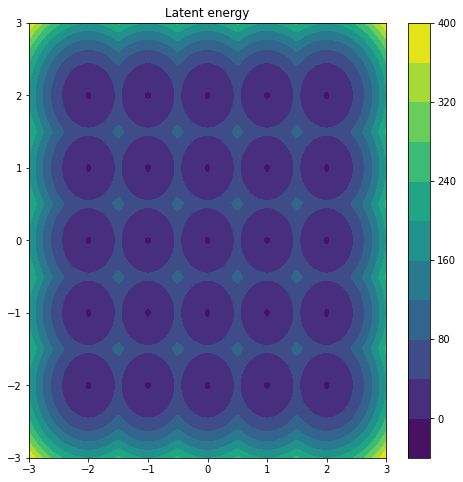

In [5]:
true_target_energy = Gaussian_mixture(target_args).energy

x_range = 3.0
y_range = 3.0
norm_grads = False
plot_potential_energy(true_target_energy,
                      x_range,
                      y_range,
                      device,
                      norm_grads = norm_grads,
                      num_points = 100)

In [12]:
%autoreload 

100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


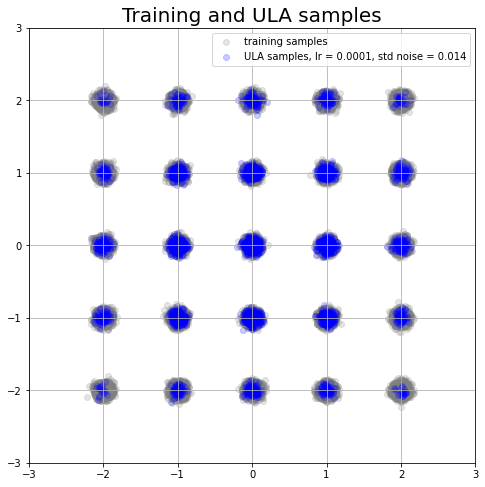

In [13]:
grad_step = 1e-4
eps_scale = (grad_step * 2) ** 0.5
n_steps = 100
n_batches = 10
batch_size_sample = 5000
langevin_sampling_plot_2d(true_target,
                          proposal,
                          X_train,  
                          batch_size_sample = batch_size_sample,
                          grad_step = grad_step,
                          eps_scale = eps_scale,
                          n_steps = n_steps,
                          n_batches = n_batches)

100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


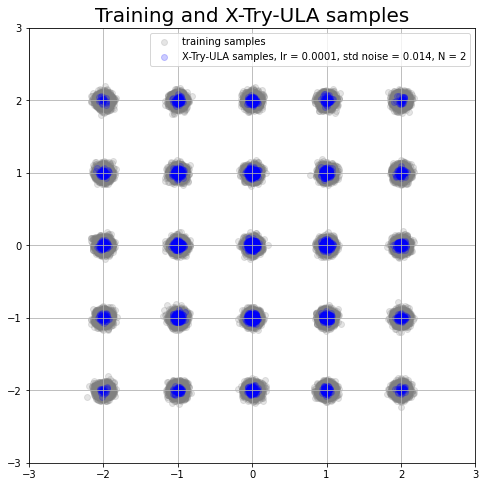

In [15]:
grad_step = 1e-4
eps_scale = (grad_step * 2) ** 0.5
N = 2
n_steps = 100
xtry_langevin_sampling_plot_2d(true_target,
                               proposal,
                               X_train,  
                               batch_size_sample = batch_size_sample,
                               N = N,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps,
                               n_batches = n_batches)

100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


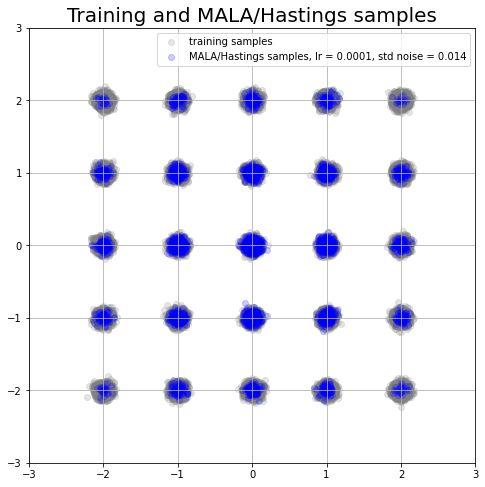

In [16]:
grad_step = 1e-4
eps_scale = (grad_step * 2) ** 0.5
n_steps = 100
n_batches = 10
acceptance_rule = 'Hastings'
mala_sampling_plot_2d(true_target,
                      proposal,
                      X_train,  
                      batch_size_sample = batch_size_sample,
                      grad_step = grad_step,
                      eps_scale = eps_scale,
                      n_steps = n_steps,
                      n_batches = n_batches,
                      acceptance_rule = acceptance_rule)

100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


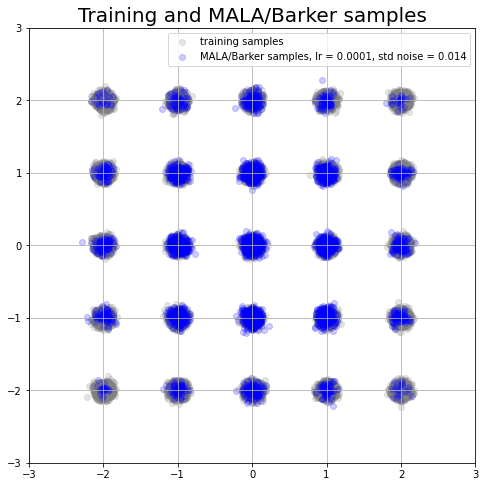

In [17]:
grad_step = 1e-4
eps_scale = (grad_step * 2) ** 0.5
n_steps = 100
n_batches = 10
acceptance_rule = 'Barker'
mala_sampling_plot_2d(true_target,
                      proposal,
                      X_train,  
                      batch_size_sample = batch_size_sample,
                      grad_step = grad_step,
                      eps_scale = eps_scale,
                      n_steps = n_steps,
                      n_batches = n_batches,
                      acceptance_rule = acceptance_rule)

# 2D Gaussians, GANs

In [18]:
G = Generator_fc(n_dim=n_dim, 
                 n_layers=n_layers_g,
                 n_hid=n_hid_g,
                 n_out=n_out,
                 non_linear=nn.ReLU(),
                 device=device)
D = Discriminator_fc(n_in=n_dim, 
                     n_layers=n_layers_d,
                     n_hid=n_hid_d,
                     non_linear=nn.ReLU(),
                     device=device)

In [19]:
discriminator_regexp = os.path.join(models_2d_path, "*_discriminator.pth")
generator_regexp = os.path.join(models_2d_path, "*_generator.pth")
discriminator_name = [f for f in glob.glob(discriminator_regexp)][0]
generator_name = [f for f in glob.glob(generator_regexp)][0]

In [20]:
G.load_state_dict(torch.load(generator_name))
D.load_state_dict(torch.load(discriminator_name))

<All keys matched successfully>

In [21]:
G = G.to(device)
D = D.to(device)

In [22]:
for p in D.parameters():  
    p.requires_grad = False
for p in G.parameters():  
    p.requires_grad = False

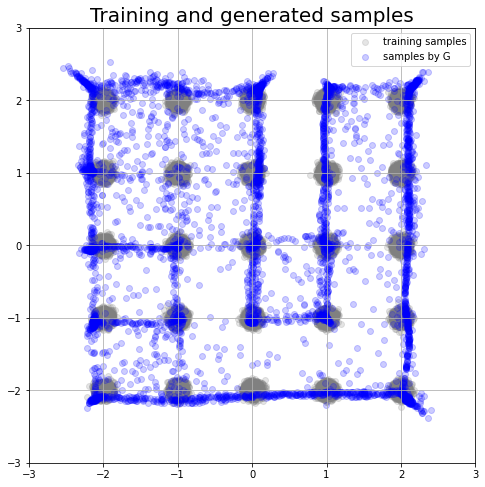

In [23]:
batch_size_sample = 5000
sample_fake_data(G, X_train,  
                 scaler = scaler,
                 batch_size_sample = batch_size_sample)

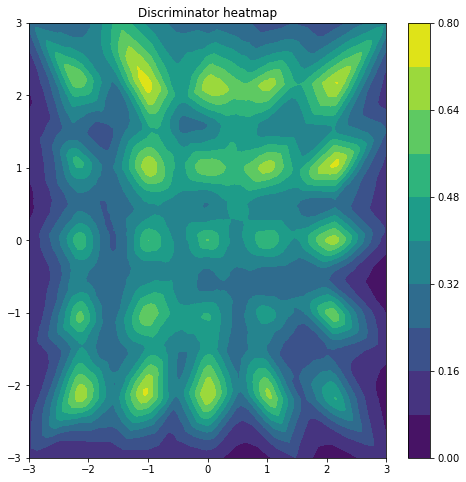

In [24]:
x_range = 3.0
y_range = 3.0
plot_discriminator_2d(D,
                      x_range,
                      y_range,
                      scaler = scaler,
                      num_points = 700)

  0%|          | 0/5000 [00:00<?, ?it/s]

Start to do MH sampling....


100%|██████████| 5000/5000 [01:08<00:00, 72.61it/s]


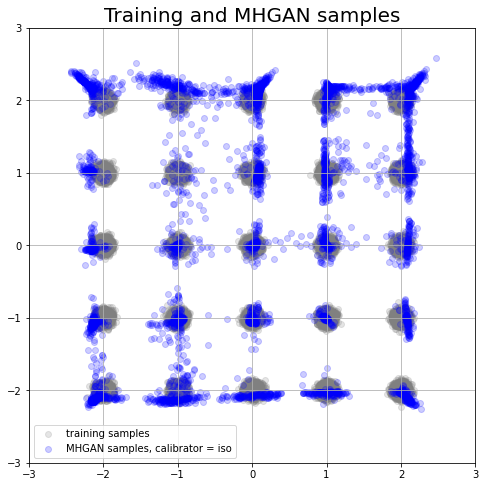

In [25]:
n_calib_pts = 10000
type_calibrator = 'iso'
normalize_to_0_1 = True
mh_sampling_plot_2d(G, 
                    D,
                    X_train, 
                    n_calib_pts = n_calib_pts,
                    scaler = scaler, 
                    batch_size_sample = batch_size_sample,
                    type_calibrator = type_calibrator,
                    normalize_to_0_1 = normalize_to_0_1)

In [26]:
n_dim = G.n_dim
loc = torch.zeros(n_dim).to(G.device)
scale = torch.ones(n_dim).to(G.device)
normal = Normal(loc, scale)
normalize_to_0_1 = True 
log_prob = True

target_gan = partial(gan_energy, 
                     generator = G, 
                     discriminator = D, 
                     proposal = normal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


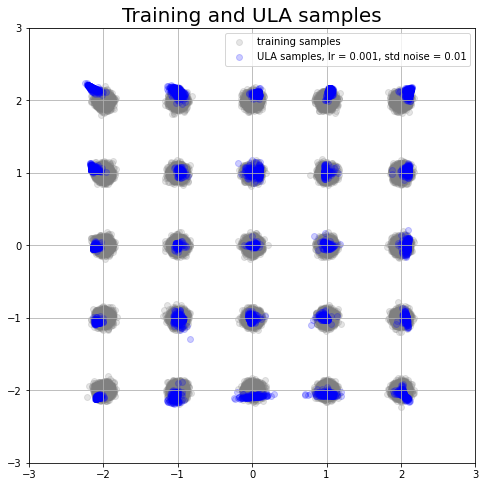

In [27]:
grad_step = 1e-3
eps_scale = 1e-2
n_steps = 1000
n_batches = 10
langevin_sampling_plot_2d(target_gan,
                          proposal,
                          X_train,  
                          scaler = scaler, 
                          batch_size_sample = batch_size_sample,
                          grad_step = grad_step,
                          eps_scale = eps_scale,
                          n_steps = n_steps,
                          n_batches = n_batches,
                          latent_transform = G)

100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


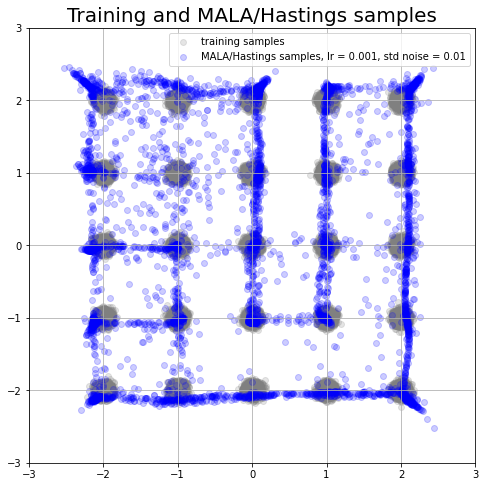

In [64]:
grad_step = 1e-3
eps_scale = 1e-2
n_steps = 500
n_batches = 10
acceptance_rule = 'Hastings'
mala_sampling_plot_2d(target_gan,
                      proposal,
                      X_train,  
                      scaler = scaler, 
                      batch_size_sample = batch_size_sample,
                      grad_step = grad_step,
                      eps_scale = eps_scale,
                      n_steps = n_steps,
                      n_batches = n_batches,
                      acceptance_rule = acceptance_rule,
                      latent_transform = G)

100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


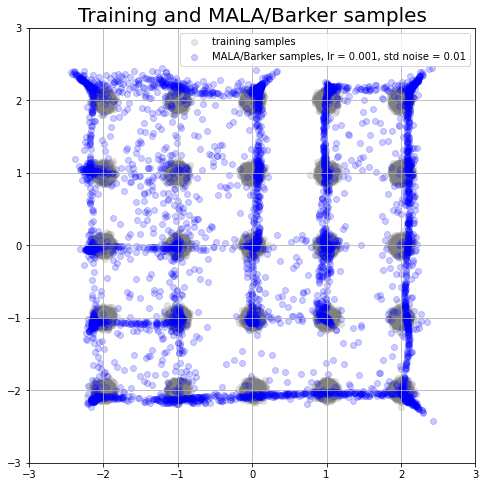

In [65]:
grad_step = 1e-3
eps_scale = 1e-2
n_steps = 500
n_batches = 10
acceptance_rule = 'Barker'
mala_sampling_plot_2d(target_gan,
                      proposal,
                      X_train,  
                      scaler = scaler, 
                      batch_size_sample = batch_size_sample,
                      grad_step = grad_step,
                      eps_scale = eps_scale,
                      n_steps = n_steps,
                      n_batches = n_batches,
                      acceptance_rule = acceptance_rule,
                      latent_transform = G)

100%|██████████| 10/10 [00:16<00:00,  1.68s/it]


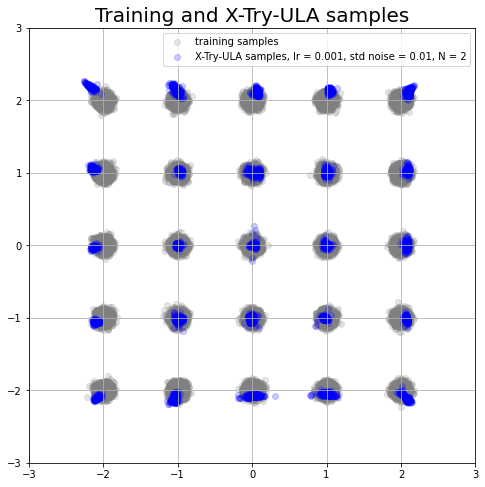

In [58]:
grad_step = 1e-3
eps_scale = 1e-2
n_steps = 500
n_batches = 10
N = 2
xtry_langevin_sampling_plot_2d(target_gan,
                               proposal,
                               X_train,  
                               scaler = scaler, 
                               batch_size_sample = batch_size_sample,
                               grad_step = grad_step,
                               eps_scale = eps_scale,
                               n_steps = n_steps,
                               n_batches = n_batches,
                               latent_transform = G)

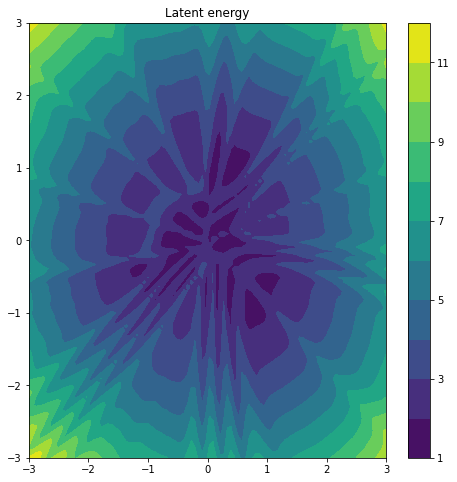

In [62]:
log_prob = False
target_gan_energy = partial(gan_energy, 
                            generator = G, 
                            discriminator = D, 
                            proposal = normal,
                            normalize_to_0_1 = normalize_to_0_1,
                            log_prob = log_prob)
x_range = 3.0
y_range = 3.0
norm_grads = False
plot_potential_energy(target_gan_energy,
                      x_range,
                      y_range,
                      device,
                      norm_grads = norm_grads,
                      num_points = 100)

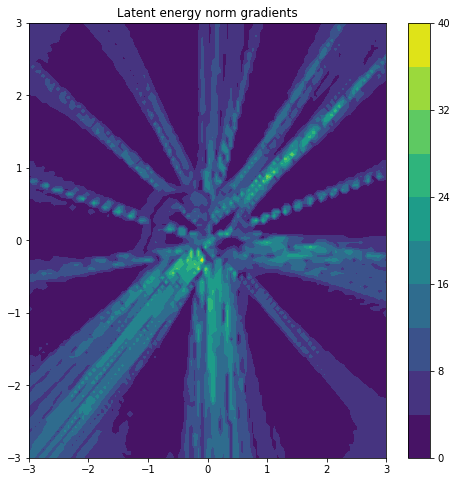

In [63]:
x_range = 3.0
y_range = 3.0
norm_grads = True
plot_potential_energy(target_gan_energy,
                      x_range,
                      y_range,
                      device,
                      norm_grads = norm_grads,
                      num_points = 100)